<a href="https://colab.research.google.com/github/Yendoh-Derek/Diabetes-Sense/blob/main/Ensemble_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Regression Model for Ensemble Network

In [5]:
# Imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [6]:
# Load dataset
df = pd.read_csv("diabetes_prediction_dataset.csv")

In [15]:
# Clean dataset

# Keep only valid smoking_history categories (including NaN for missing)
valid_smoking_categories = ['current', 'former', 'never', 'not current', np.nan]
df = df[df['smoking_history'].isin(valid_smoking_categories)]

# Keep only valid genders
valid_genders = ['Male', 'Female']
df = df[df['gender'].isin(valid_genders)]

# Replace 'No Info' with np.nan in smoking_history
df['smoking_history'] = df['smoking_history'].replace("No Info", np.nan)

# Step 1: Define target and features
target = 'diabetes'  # to be replaced later with continuous risk score
X = df.drop(columns=[target])
y = df[target]

# Step 2: Define categorical and numerical features
categorical_features = ['gender', 'smoking_history']
numerical_features = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']

# Step 3: Create preprocessing pipelines

# Categorical pipeline: impute missing then one-hot encode all categories
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop=None, sparse_output=False, handle_unknown='ignore'))
])

# Numerical pipeline: impute median then scale
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Combine pipelines into a preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_pipeline, categorical_features),
    ('num', numerical_pipeline, numerical_features)
])

# Step 4: Fit and transform features
X_processed = preprocessor.fit_transform(X)

# Step 5: Extract encoded feature names
encoded_cat_features = preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([encoded_cat_features, numerical_features])

# Step 6: Convert to DataFrame for easy inspection
X_clean = pd.DataFrame(X_processed, columns=all_feature_names)

# Preview processed data
print(X_clean.head())

   gender_Female  gender_Male  smoking_history_current  \
0            1.0          0.0                      0.0   
1            1.0          0.0                      0.0   
2            0.0          1.0                      0.0   
3            1.0          0.0                      1.0   
4            0.0          1.0                      1.0   

   smoking_history_former  smoking_history_never  smoking_history_not current  \
0                     0.0                    1.0                          0.0   
1                     0.0                    1.0                          0.0   
2                     0.0                    1.0                          0.0   
3                     0.0                    0.0                          0.0   
4                     0.0                    0.0                          0.0   

        age       bmi  HbA1c_level  blood_glucose_level  
0  1.694465 -0.311753     1.004813             0.049064  
1  0.547603  0.008937     1.004813            -1

In [16]:
preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out()


array(['x0_Female', 'x0_Male', 'x1_current', 'x1_former', 'x1_never',
       'x1_not current'], dtype=object)

In [17]:
print (df.head())

   gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0             NaN  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0  


Train-Test Split and Stratified K-Fold Validation

In [18]:
from sklearn.model_selection import train_test_split, StratifiedKFold

# Step 1: Train-test split (80/20) with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y, test_size=0.2, stratify=y, random_state=42
)

# Step 2: Set up Stratified K-Fold cross-validator (5 folds)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Confirm shape
print("Training set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape, y_test.shape)


Training set: (76783, 10) (76783,)
Test set: (19196, 10) (19196,)


Feature Selection

In [19]:
from sklearn.feature_selection import SelectKBest, chi2
from scipy.stats import pearsonr

# Step 1: Chi-Square Test for Categorical Features
# Identify one-hot encoded categorical columns
cat_feature_mask = [col.startswith('gender_') or col.startswith('smoking_history_') for col in X_train.columns]
cat_features = X_train.loc[:, cat_feature_mask]
chi2_selector = SelectKBest(score_func=chi2, k='all')
chi2_selector.fit(cat_features, y_train)
chi2_scores = pd.Series(chi2_selector.scores_, index=cat_features.columns).sort_values(ascending=False)

# Step 2: Pearson Correlation for Numerical Features
num_features = X_train.loc[:, ~pd.Series(cat_feature_mask).values]
pearson_scores = {}
for col in numerical_features:
    corr, _ = pearsonr(X_train[col], y_train)
    pearson_scores[col] = abs(corr)
pearson_scores = pd.Series(pearson_scores).sort_values(ascending=False)

# Step 3: Display top features
print("Top categorical features (Chi-Square):\n", chi2_scores)
print("\nTop numerical features (Pearson Correlation):\n", pearson_scores)


Top categorical features (Chi-Square):
 smoking_history_former         813.003923
smoking_history_never          189.674895
gender_Male                     62.672990
gender_Female                   44.080198
smoking_history_not current     33.284720
smoking_history_current         20.871985
dtype: float64

Top numerical features (Pearson Correlation):
 blood_glucose_level    0.416910
HbA1c_level            0.397958
age                    0.258672
bmi                    0.215953
dtype: float64


<ipython-input-20-82f9eb929b95>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=chi2_scores.values, y=chi2_scores.index, palette="viridis")


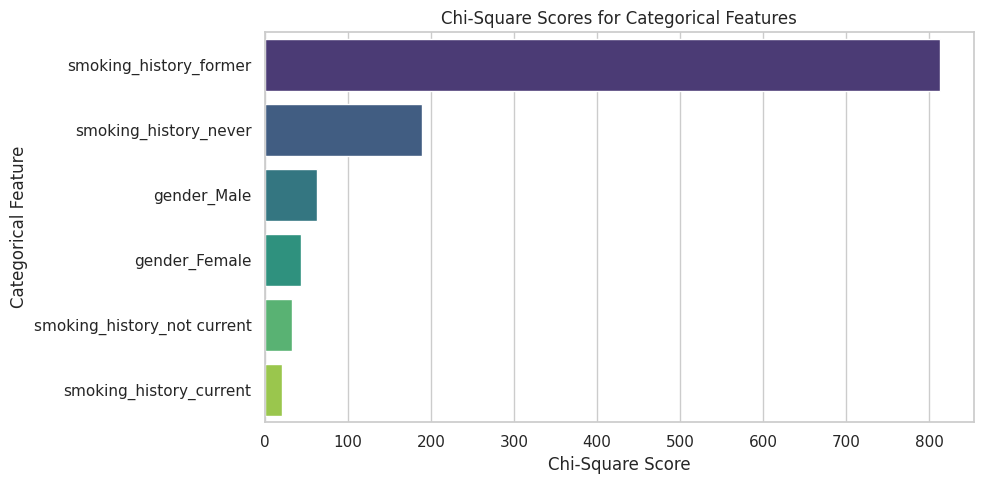

<ipython-input-20-82f9eb929b95>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pearson_scores.values, y=pearson_scores.index, palette="rocket")


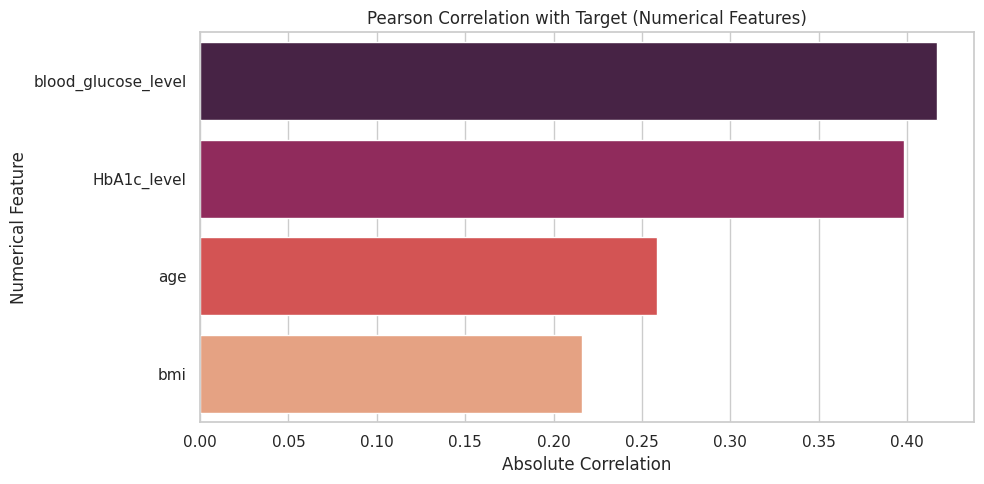

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# Plot Chi-Square scores for categorical features
plt.figure(figsize=(10, 5))
sns.barplot(x=chi2_scores.values, y=chi2_scores.index, palette="viridis")
plt.title("Chi-Square Scores for Categorical Features")
plt.xlabel("Chi-Square Score")
plt.ylabel("Categorical Feature")
plt.tight_layout()
plt.show()

# Plot Pearson correlation for numerical features
plt.figure(figsize=(10, 5))
sns.barplot(x=pearson_scores.values, y=pearson_scores.index, palette="rocket")
plt.title("Pearson Correlation with Target (Numerical Features)")
plt.xlabel("Absolute Correlation")
plt.ylabel("Numerical Feature")
plt.tight_layout()
plt.show()


Base Learners Modeling

Random Forest Regressor – Grid Search

In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

rf = RandomForestRegressor(random_state=42)

rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_grid = GridSearchCV(rf, rf_param_grid, cv=skf, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
rf_grid.fit(X_train, y_train)

best_rf = rf_grid.best_estimator_
print("Best RF Params:", rf_grid.best_params_)


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best RF Params: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}


Multi-Layer Perceptron Regressor – Optuna

In [25]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 20.4 MB/s eta 0:00:00


In [26]:
import optuna
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score

def objective(trial):
    hidden_layer_sizes = trial.suggest_categorical("hidden_layer_sizes", [(50,), (100,), (50,50)])
    activation = trial.suggest_categorical("activation", ["relu", "tanh"])
    learning_rate_init = trial.suggest_loguniform("learning_rate_init", 1e-4, 1e-1)

    mlp = MLPRegressor(
        hidden_layer_sizes=hidden_layer_sizes,
        activation=activation,
        learning_rate_init=learning_rate_init,
        max_iter=500,
        random_state=42
    )

    score = cross_val_score(mlp, X_train, y_train, cv=skf, scoring='neg_mean_squared_error').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

best_mlp_params = study.best_params
best_mlp = MLPRegressor(
    **best_mlp_params,
    max_iter=500,
    random_state=42
)
best_mlp.fit(X_train, y_train)

print("Best MLP Params:", best_mlp_params)


[I 2025-05-15 11:37:19,969] A new study created in memory with name: no-name-16f5be8a-a429-448b-ac22-18aa4e55de9a
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
<ipython-input-26-b342647513a6>:8: FutureWarning: suggest_loguniform has been deprecated i

Best MLP Params: {'hidden_layer_sizes': (50, 50), 'activation': 'relu', 'learning_rate_init': 0.0007677080770572481}


Linear Regression (Baseline)

In [27]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)


LinearRegression()

Training The Meta Learner

In [28]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBRegressor

# Prepare containers
meta_X_train = np.zeros((X_train.shape[0], 3))  # 3 base models
meta_X_test = np.zeros((X_test.shape[0], 3))

skf_meta = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf_meta.split(X_train, y_train)):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Train each base model
    rf_fold = RandomForestRegressor(**rf_grid.best_params_, random_state=42)
    rf_fold.fit(X_tr, y_tr)
    meta_X_train[val_idx, 0] = rf_fold.predict(X_val)
    meta_X_test[:, 0] += rf_fold.predict(X_test) / skf_meta.n_splits

    mlp_fold = MLPRegressor(**best_mlp_params, max_iter=500, random_state=42)
    mlp_fold.fit(X_tr, y_tr)
    meta_X_train[val_idx, 1] = mlp_fold.predict(X_val)
    meta_X_test[:, 1] += mlp_fold.predict(X_test) / skf_meta.n_splits

    lr_fold = LinearRegression()
    lr_fold.fit(X_tr, y_tr)
    meta_X_train[val_idx, 2] = lr_fold.predict(X_val)
    meta_X_test[:, 2] += lr_fold.predict(X_test) / skf_meta.n_splits


Train the Meta-Learner: XGBoost Regressor

In [29]:
from sklearn.model_selection import GridSearchCV

xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [2, 4, 6],
    'learning_rate': [0.01, 0.1, 0.2],
}

xgb_grid = GridSearchCV(xgb, xgb_param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
xgb_grid.fit(meta_X_train, y_train)

best_xgb = xgb_grid.best_estimator_
print("Best XGBoost Params:", xgb_grid.best_params_)


Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best XGBoost Params: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100}


Final Predictions on Test Set

In [30]:
final_predictions = best_xgb.predict(meta_X_test)


Evaluate Ensemble Performance

In [36]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

mse = mean_squared_error(y_test, final_predictions)
r2 = r2_score(y_test, final_predictions)

print(f"Ensemble MSE: {mse:.4f}")
print(f"Ensemble R² Score: {r2:.4f}")
# Corrected the variable names to y_test and final_predictions
print(f"Mean Absolute Error: {mean_absolute_error(y_test, final_predictions):.2f} mmol/L")

Ensemble MSE: 0.0230
Ensemble R² Score: 0.6999
Mean Absolute Error: 0.05 mmol/L


Explaining SHAP Values for Individual Base Learners

TreeExplainer: Random Forest Regressor


In [38]:
!pip install shap


100%|===================| 19133/19196 [03:18<00:00]       

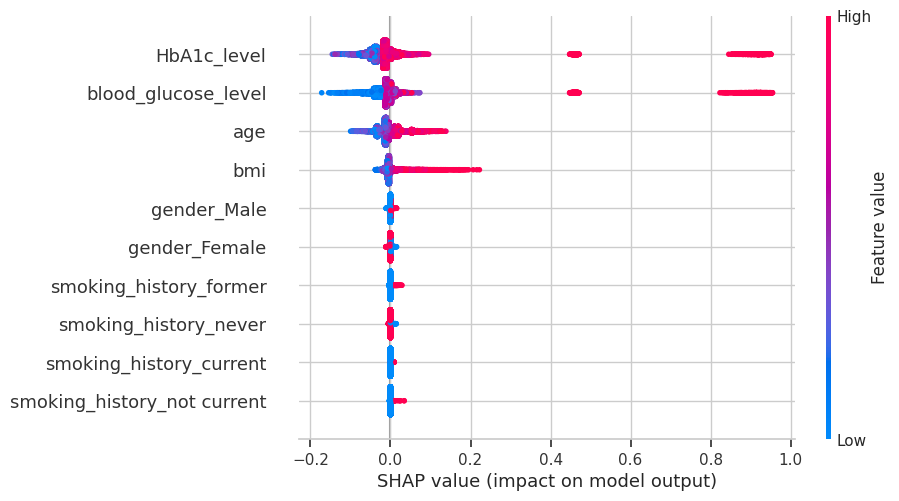

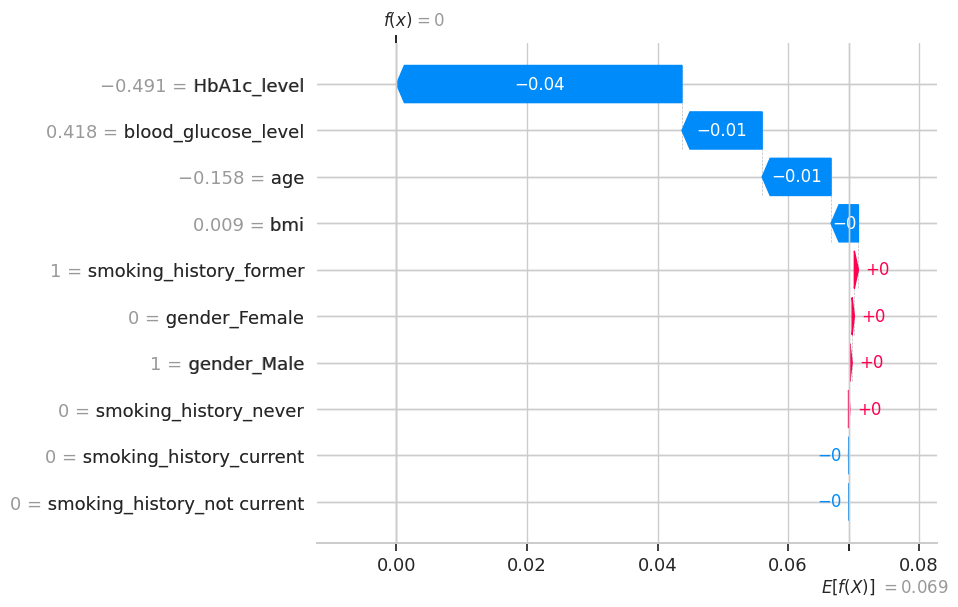

In [40]:
import shap

# Use X_test instead of X_test_scaled
rf_explainer = shap.Explainer(best_rf, X_test)
rf_shap_values = rf_explainer(X_test)

# Global explanation
shap.plots.beeswarm(rf_shap_values, max_display=10)

# Local explanation (e.g., first sample)
shap.plots.waterfall(rf_shap_values[0])